In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [4]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/lusc.HRD_Score.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]

In [5]:
# Normalize HIFs and define X, y
X = df.iloc[:,1:608]
X_normalized = (X-X.mean())/X.std()

In [6]:
y = df.iloc[:,609]
print(np.sum(y))

54


In [7]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/LUSC.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 25


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,3
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,3


## Define Nested CV Parameters

In [11]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

96 96
96 96
96 96
0.1875
0.1875
0.1875


### Outer Loop 1

In [12]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(192, 607) (192,)
(96, 607) (96,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5889112903225806, 0.5879896313364055, 0.5888824884792626, 0.5915034562211982, 0.5959965437788017, 0.6046947004608295, 0.6081221198156681, 0.6119239631336406, 0.6147753456221199, 0.6123847926267281, 0.6130760368663595, 0.6108870967741936, 0.6012096774193548, 0.5967165898617511, 0.5889688940092166, 0.5808179723502305, 0.5830357142857142, 0.5769585253456221, 0.5950172811059907, 0.5987615207373272, 0.6057315668202765, 0.5696716589861751, 0.5446716589861751, 0.5032258064516129, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


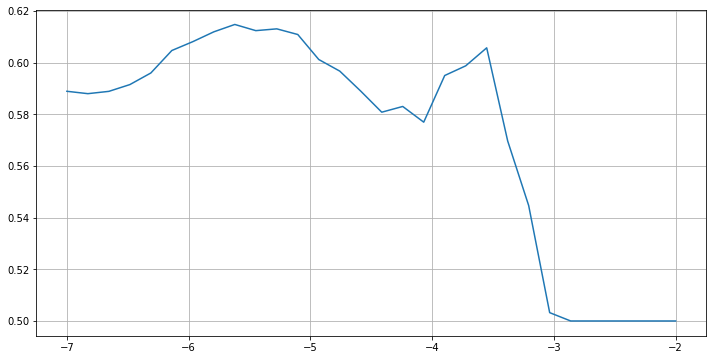

0.0036221422182623098 -5.620689655172414


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.9
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

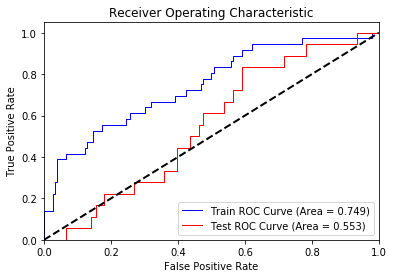

In [14]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

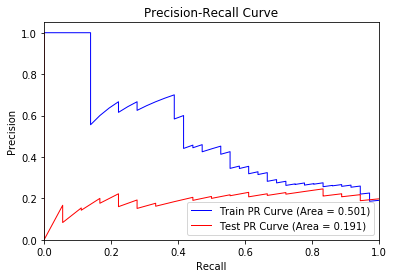

In [15]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 20


,HIF,Beta,Cluster
538,REGION PROPERTIES: STANDARD DEVIATION OF SOLIDITIES OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.263908,21
221,COUNT PROP [LYMPHOCYTE CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.074211,11
273,COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.071749,17
280,COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.053234,11
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.045352,17
247,COUNT PROP [PLASMA CELLS] IN [[TUMOR] OVER [STROMA]]_HE,0.039674,11
365,DENSITY RATIO [LYMPHOCYTE CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.027171,11
176,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN EPITHE...,0.020848,11
358,DENSITY RATIO [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,0.018014,11
597,TOTAL [LYMPHOCYTE CELLS] IN [STROMA]_HE,0.017058,3


### Outer Loop 2

In [16]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(192, 607) (192,)
(96, 607) (96,)


In [42]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5019297235023041, 0.5057891705069124, 0.5058467741935484, 0.5095334101382488, 0.5116935483870968, 0.5199020737327189, 0.5175115207373271, 0.5180875576036866, 0.5303571428571427, 0.5295506912442396, 0.5425403225806452, 0.5507776497695852, 0.5455069124423964, 0.5475230414746544, 0.5525633640552995, 0.553225806451613, 0.5651785714285714, 0.5799539170506913, 0.5779089861751151, 0.5800691244239631, 0.5866935483870968, 0.5767569124423962, 0.5824596774193549, 0.5795794930875575, 0.5654665898617511, 0.5507488479262672, 0.5387960829493087, 0.5105414746543778, 0.4622983870967742, 0.40391705069124423]


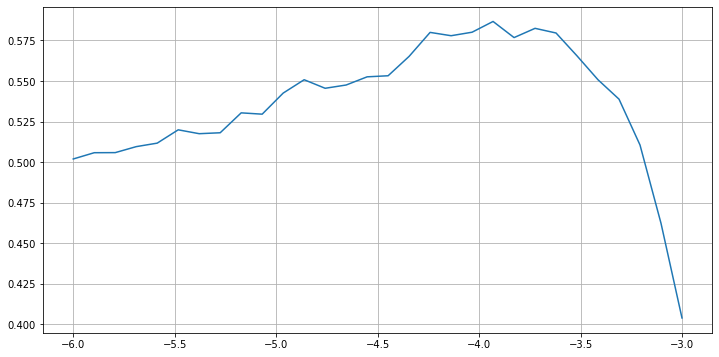

0.019623362019752715 -3.93103448275862


In [44]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.9
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

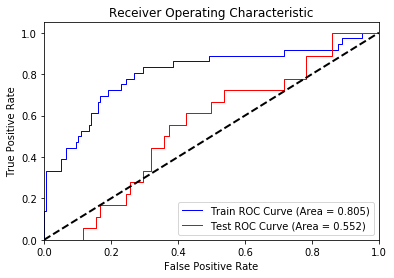

In [18]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

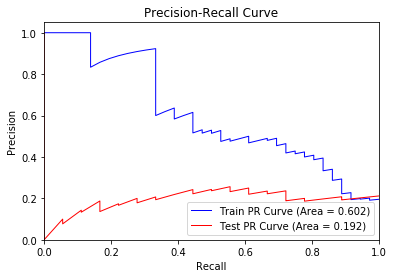

In [19]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 34


,HIF,Beta,Cluster
541,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF EPITHELIAL_HE,0.149619,1
578,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [MACROPHAGE_RADIUS_80]_HE,0.089694,1
542,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF ESI_0080_HE,0.089128,1
41,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN ESI_0080_HE,0.089019,1
581,TOTAL [CANCER CELLS] IN [STROMA] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,0.065674,1
29,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF CANCER IN ESI_0080_HE,0.046535,1
545,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF TUMOR_HE,0.043637,1
37,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF LYMPHOCYTE IN ESI_0080_HE,0.041946,1
451,REGION PROPERTIES: EXTENT OF LARGEST REGION OF EPITHELIAL_HE,0.039759,3
527,REGION PROPERTIES: STANDARD DEVIATION OF ECCENTRICITIES OF SIGNIFICANT REGIONS OF ESI_0080_HE,0.038674,6


### Outer Loop 3

In [20]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(192, 607) (192,)
(96, 607) (96,)


In [50]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.4779377880184331, 0.47885944700460836, 0.4733582949308756, 0.47425115207373275, 0.47183179723502305, 0.4690092165898617, 0.465610599078341, 0.46296082949308753, 0.4650633640552996, 0.4705645161290323, 0.4685483870967742, 0.47370391705069126, 0.46379608294930874, 0.4691820276497696, 0.4824020737327189, 0.4939228110599078, 0.49916474654377885, 0.4936635944700461, 0.4913306451612902, 0.4882200460829493, 0.49279953917050695, 0.47764976958525346, 0.48401497695852524, 0.4775057603686636, 0.48202764976958523, 0.4907258064516129, 0.48312211981566816, 0.4923387096774194, 0.4856566820276497, 0.47767857142857145]


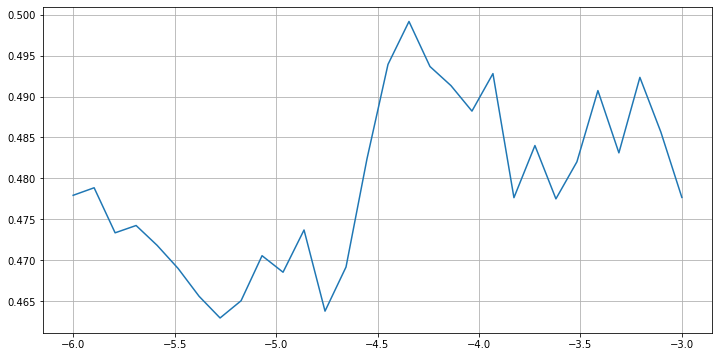

0.01297374490751713 -4.344827586206897


In [52]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.9
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

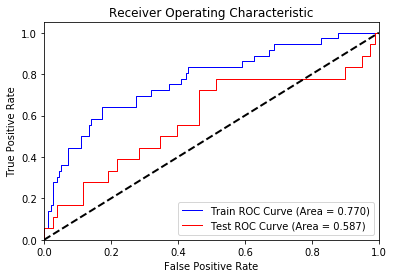

In [22]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

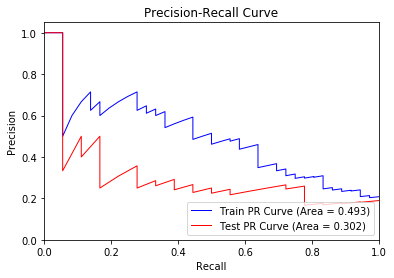

In [23]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 51


,HIF,Beta,Cluster
578,TOTAL [CANCER CELLS] IN [ESI_0080] SELECTED BY [MACROPHAGE_RADIUS_80]_HE,0.029366,1
542,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF ESI_0080_HE,0.026677,1
93,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN ESI_0080_HE,0.019912,8
538,REGION PROPERTIES: STANDARD DEVIATION OF SOLIDITIES OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.019331,21
33,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN ESI_0080_HE,0.018612,1
581,TOTAL [CANCER CELLS] IN [STROMA] SELECTED BY [FIBROBLAST_RADIUS_80]_HE,0.017064,1
595,TOTAL [LYMPHOCYTE CELLS] IN [EPITHELIAL]_HE,0.014965,1
153,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN ESI_0080_HE,0.014909,8
173,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN ESI_00...,0.013403,8
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.012625,8


## Compute Ensemble Model

In [ ]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

## Compute Final Train / Test Metrics

In [26]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7487535612535613, 0.8046652421652422, 0.7702991452991453]
0.7745726495726496 0.023025002999263633


In [27]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.5527065527065527, 0.551994301994302, 0.586894586894587]
0.5638651471984806 0.016286868837742198


In [28]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.5005356440088812, 0.6019099249000901, 0.492540206380058]
0.5316619250963431 0.049779968280688494


In [29]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.19087382818798476, 0.19218201836090487, 0.3019845507871992]
0.2283467991120296 0.05207249238137533


## Evaluate Hold-Out Set

In [30]:
holdout_df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/lusc.HRD_Score.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,bcr_patient_barcode,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,...,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE,HRD_Score,HRD_Score_Binarized
0,TCGA-33-4532,44.614060,48.970184,52.671736,56.416952,101.031012,6681.995336,6068.722504,5635.209993,6415.732053,...,27.771514,117.214181,279.543638,168.364145,7.957133,290.830028,871.971956,490.433571,45,0
1,TCGA-33-4533,141.079780,133.991280,23.540920,102.211936,243.291716,6653.555564,6227.367567,5832.030841,6734.980601,...,77.821216,213.051178,485.980424,249.297432,77.764510,468.970817,1453.978917,655.940953,32,0
2,TCGA-33-4538,155.368068,141.359540,39.170800,138.627560,293.995628,6641.103506,6431.448008,5484.909379,6555.388437,...,15.312027,126.118124,531.019950,258.483436,20.506144,516.533939,1832.940001,875.121857,36,0
3,TCGA-33-4547,106.002212,166.184464,44.307036,147.375092,253.377304,5903.440095,6007.808063,5381.069213,6023.511051,...,401.925575,373.530705,433.960713,420.558583,57.253522,300.334934,993.037548,601.545591,42,0
4,TCGA-33-4566,49.889124,31.114740,10.044648,44.979312,94.868436,6298.614026,5621.425514,5179.342346,6219.452140,...,77.070906,325.794141,726.978661,385.207152,28.302762,202.347826,959.974666,470.029884,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,TCGA-85-A510,42.810968,71.876072,71.635612,89.004812,131.815780,5849.430848,5578.271804,4812.196856,5798.166444,...,153.722289,459.735752,908.984561,663.691403,44.661452,400.147075,1116.310430,768.261584,31,0
92,TCGA-85-A512,47.872360,35.150752,10.031736,22.948752,70.821112,6923.732594,5998.358443,5186.177105,7016.332174,...,127.798170,309.609308,481.159063,242.300629,18.841770,110.381707,250.122534,93.785593,48,1
93,TCGA-85-A513,20.681632,48.952788,4.349976,58.916880,79.598512,6355.898094,6468.830562,6701.191267,6498.534393,...,510.114482,853.822667,1636.780495,1344.045225,185.962114,1067.763495,1332.894749,1034.893718,24,0
94,TCGA-85-A53L,107.337592,179.691200,79.234320,183.314796,290.652388,6385.322963,6357.834926,5874.068158,6455.274255,...,201.541693,410.454157,869.411545,622.767978,67.730232,444.390154,1118.382174,730.377622,53,1


In [31]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,1:608]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._FFPE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE
0,0.058995,-0.057220,1.821936,0.229684,0.176573,0.447597,-0.247620,0.251256,-0.071512,0.564300,...,2.046961,1.535501,-0.508999,-1.016922,-1.226012,-0.953589,-0.885635,-0.355518,-0.001942,0.068392
1,2.941559,2.022033,0.298624,1.273439,2.260874,0.406944,0.044343,0.537604,0.507152,1.385638,...,0.251666,-0.084043,-0.343979,-0.679430,-0.723077,-0.703931,0.333872,0.343235,1.098551,0.577144
2,3.368518,2.202229,1.115944,2.103421,3.003752,0.389145,0.419924,0.032589,0.181626,-0.055336,...,1.806617,0.938321,-0.550079,-0.985567,-0.613349,-0.675595,-0.666409,0.529800,1.815112,1.250882
3,1.893380,2.809341,1.384528,2.302794,2.408641,-0.665293,-0.359724,-0.118485,-0.782445,0.319830,...,-0.034085,0.175574,0.724634,-0.114298,-0.849811,-0.175635,-0.024447,-0.318235,0.226976,0.409938
4,0.216623,-0.493888,-0.407125,-0.031002,0.086283,-0.100419,-1.070806,-0.411970,-0.427286,-1.994250,...,0.180231,0.024623,-0.346453,-0.282404,-0.135942,-0.284685,-0.530205,-0.702587,0.164458,0.005673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.005116,0.502960,2.813598,0.972424,0.627609,-0.742495,-1.150224,-0.946118,-1.190900,-1.678213,...,-0.275631,0.065597,-0.093723,0.189275,0.307472,0.574366,-0.244425,0.073276,0.460067,0.922405
92,0.156359,-0.395184,-0.407800,-0.533121,-0.266041,0.793143,-0.377115,-0.402027,1.017124,0.106634,...,-1.076390,-1.022834,-0.179198,-0.339399,-0.734824,-0.725515,-0.695485,-1.063323,-1.177772,-1.150861
93,-0.656147,-0.057645,-0.704911,0.286662,-0.137441,-0.018536,0.488721,1.802116,0.078574,0.025804,...,1.937611,2.647515,1.081346,1.577060,2.080575,2.673080,2.224040,2.691986,0.869598,1.742003
94,1.933283,3.139658,3.210951,3.121929,2.954769,0.023525,0.284449,0.598763,0.000161,0.585558,...,1.286536,1.375668,0.063943,0.015728,0.211062,0.448128,0.158577,0.246818,0.463985,0.805954


In [32]:
y_holdout = holdout_df.iloc[:,609]
print(np.sum(y_holdout))

19


In [33]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [34]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

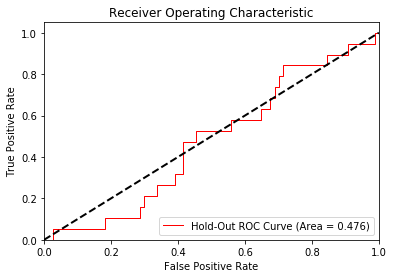

In [35]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.476


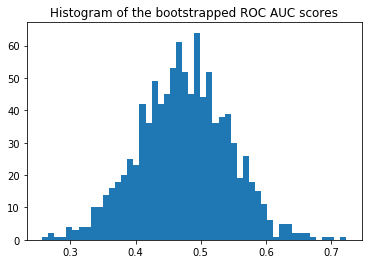

Confidence interval for the score: [0.338 - 0.606]


In [36]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

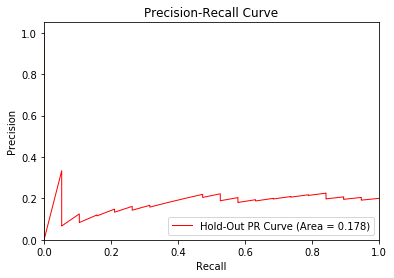

In [37]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.178


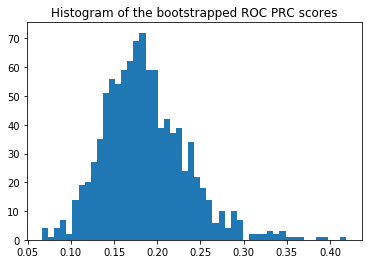

Confidence interval for the score: [0.106 - 0.295]


In [38]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))